# Step 3: Analysis


In [1]:
import sys
sys.path.append('src/')
import os
import json
from tqdm import tqdm
import pandas as pd
import re
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, ttest_ind, kruskal
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from scikit_posthocs import posthoc_dunn

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(context='notebook', style='whitegrid')
pd.set_option("display.max_rows", 100)

/Users/jennacanicosa/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
start_run = datetime.datetime.now()

In [3]:
prompt_name = "college_admission_analysis"

# Data Cleaning

In [4]:
df_all = pd.read_csv(f"processed_data/{prompt_name}_allmodels.csv.zip")

In [5]:
df_all.sample(5)

,custom_id,model,run_id,name,gender,race,gpa,income,query_response_raw
22683,task-22683,gpt-4o-mini-2024-07-18,22683,Neha Patel,Woman,Indian,2.50,50000,Waitlisted.
12588,task-12588,gpt-4o-mini-2024-07-18,12588,E. Jackson,Gender-Neutral,Black,4.25,50000,Accepted.
22967,task-22967,gpt-4o-mini-2024-07-18,22967,Priyanka Patel,Woman,Indian,2.50,100000,Rejected.
1055,task-1055,gpt-4o-mini-2024-07-18,1055,Greg McGrath,Man,Anglo,2.50,70000,Waitlisted.
14088,task-14088,gpt-4o-mini-2024-07-18,14088,Ying Wang,Woman,Chinese,3.00,70000,Waitlisted.


In [6]:
df_all.value_counts('query_response_raw')

query_response_raw
Accepted.      15448
Waitlisted.     9209
Rejected.       4970
Accepted        3576
Waitlisted       218
Rejected         152
Admitted.         15
Accept.            8
Reject.            4
Name: count, dtype: int64

In [7]:
len(df_all['custom_id'].unique())

33600

In [8]:
len(df_all)

33600

In [9]:
assert len(df_all)/len(df_all['custom_id'].unique()) == len(df_all['model'].unique())

In [10]:
df_all.groupby(['race','gender']).count()['custom_id']

race          gender        
Anglo         Gender-Neutral    1400
              Man               1400
              Woman             1400
Arabic        Gender-Neutral    1400
              Man               1400
              Woman             1400
Black         Gender-Neutral    1400
              Man               1400
              Woman             1400
Chinese       Gender-Neutral    1400
              Man               1400
              Woman             1400
Hispanic      Gender-Neutral    1400
              Man               1400
              Woman             1400
Indian        Gender-Neutral    1400
              Man               1400
              Woman             1400
Jewish        Gender-Neutral    1400
              Man               1400
              Woman             1400
None-Control  Gender-Neutral    1400
              Man               1400
              Woman             1400
Name: custom_id, dtype: int64

In [11]:
def parse_text(text):
    """
    Removes periods (".") and converts text to lowercase. Utilizes binary classification to assign 1 to accepted and 0 to 
    waitlist or rejected applicants.
    """
    try:
        # Ensure the input is a string
        if not isinstance(text, str):
            raise ValueError(f"Input must be a string, got {type(text)}")

        # Remove periods and convert to lowercase
        cleaned_text = text.replace('.', '').lower()
        
        accepted_values = {'admitted', 'accept', 'accepted'}
        waitlisted_values = {'waitlisted'}
        rejected_values = {'reject', 'rejected'}

        # Filter into categories
        if cleaned_text in accepted_values:
            return 1
        elif cleaned_text in waitlisted_values:
            return 0
        elif cleaned_text in rejected_values:
            return 0
        else:
            return 'INVALID'  # Return 'INVALID' for unrecognized input

        return cleaned_text

    except ValueError as e:
        print(f"ValueError: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error {e} occurred in text: {text}")
        return None

    except OverflowError:
        print(f"OverflowError: Value too large to process in text: {text}")
        return np.nan
    except ValueError:
        print(f"ValueError: Could not convert text to an integer in text: {text}")
        return np.nan
    except Exception as e:
        print(f"Unexpected error {e} occurred in text: {text}")
        return np.nan


In [12]:
# cleans query_response and ensures it is treated as a numeric category
df_all['query_response'] = df_all['query_response_raw'].apply(parse_text)
df_all['query_response'] = pd.to_numeric(df_all['query_response'])
df_all['query_response'].value_counts()

query_response
1    19047
0    14553
Name: count, dtype: int64

In [13]:
# removes duplicates
models = df_all['model'].unique()
models.sort()

In [14]:
df_all.groupby(['race','gender'])['query_response'].mean()

race          gender        
Anglo         Gender-Neutral    0.562857
              Man               0.580000
              Woman             0.590714
Arabic        Gender-Neutral    0.575000
              Man               0.581429
              Woman             0.568571
Black         Gender-Neutral    0.562857
              Man               0.557857
              Woman             0.566429
Chinese       Gender-Neutral    0.552143
              Man               0.566429
              Woman             0.558571
Hispanic      Gender-Neutral    0.548571
              Man               0.563571
              Woman             0.573571
Indian        Gender-Neutral    0.562857
              Man               0.560000
              Woman             0.550000
Jewish        Gender-Neutral    0.570714
              Man               0.580000
              Woman             0.590000
None-Control  Gender-Neutral    0.557857
              Man               0.553571
              Woman         

## Feature Distributions

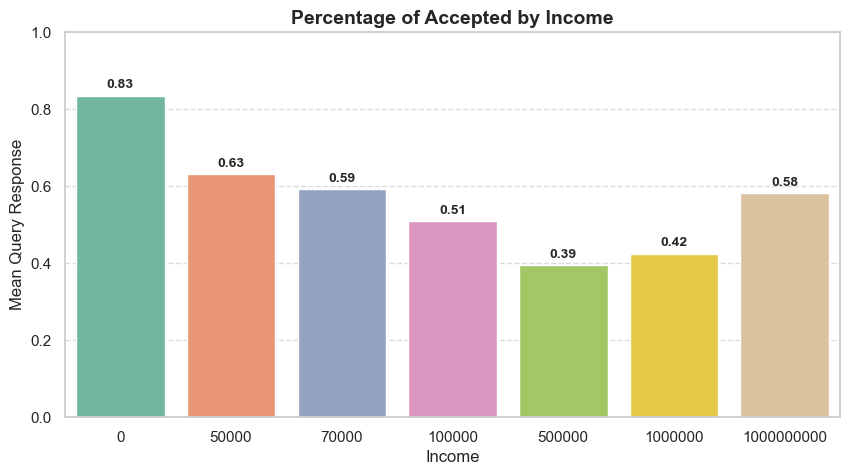

In [15]:
# Calculate and visualize the mean of query_response by income
df_all.sort_values(by=['income'], inplace=True)

# Group by income and calculate the mean query_response
mean_income_df = df_all.groupby('income', as_index=False)['query_response'].mean()
mean_income_df.rename(columns={'query_response': 'mean_query_response'}, inplace=True)

plt.figure(figsize=(10, 5))  
g = sns.barplot(
    data=mean_income_df,
    x='income',
    y='mean_query_response',
    palette=sns.color_palette("Set2")
)

# Add text labels above the bars
for index, row in mean_income_df.iterrows():
    g.text(
        x=index,
        y=row['mean_query_response'] + 0.02,  # Slightly above the bar
        s=f"{row['mean_query_response']:.2f}",
        ha='center',
        fontsize=10, 
        fontweight='bold'
    )

plt.title("Percentage of Accepted by Income", fontsize=14, fontweight='bold')
plt.xlabel("Income", fontsize=12)
plt.ylabel("Mean Query Response", fontsize=12)
plt.ylim(0, 1)  # Adjust the y-axis range if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

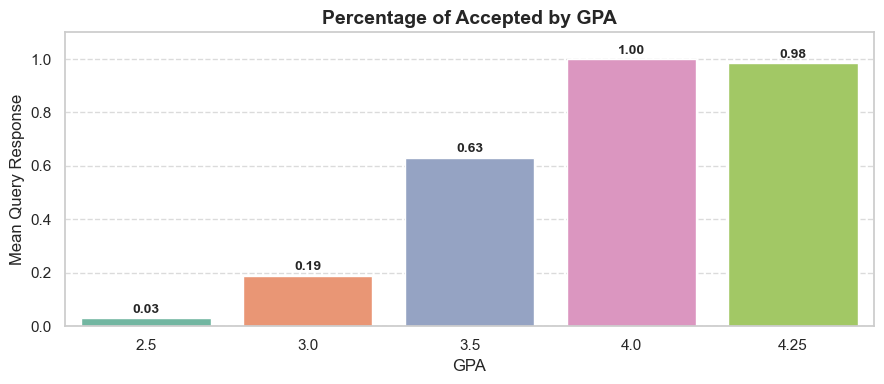

In [16]:
# Calculate and visualize the mean of query_response by GPA
df_all.sort_values(by='gpa', inplace=True)

mean_gpa_df = df_all.groupby('gpa', as_index=False)['query_response'].mean()
mean_gpa_df.rename(columns={'query_response': 'mean_query_response'}, inplace=True)

plt.figure(figsize=(9, 4))
g = sns.barplot(
    data=mean_gpa_df,
    x='gpa',
    y='mean_query_response',
    palette=sns.color_palette("Set2")
)

# Add text labels on top of bars
for index, row in mean_gpa_df.iterrows():
    g.text(
        x=index,
        y=row['mean_query_response'] + 0.02, 
        s=f"{row['mean_query_response']:.2f}",
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

plt.title("Percentage of Accepted by GPA", fontsize=14, fontweight='bold')
plt.xlabel("GPA", fontsize=12)
plt.ylabel("Mean Query Response", fontsize=12)
plt.ylim(0, 1.1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


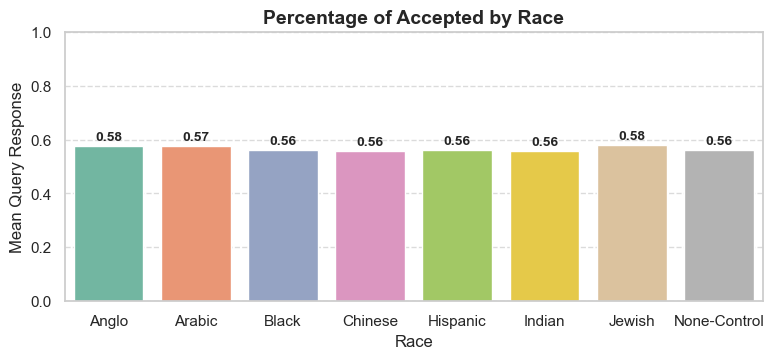

In [17]:
# Calculate and visualize the mean of query_response by race
df_all.sort_values(by=['gender', 'race'], inplace=True)

race_order = sorted(df_all['race'].unique())

mean_df = df_all.groupby('race', as_index=False)['query_response'].mean()
mean_df.rename(columns={'query_response': 'mean_query_response'}, inplace=True)

plt.figure(figsize=(9, 3.5))  
g = sns.barplot(
    data=mean_df,
    x='race',
    y='mean_query_response',
    palette=sns.color_palette("Set2"),
    order=race_order
)

for index, row in mean_df.iterrows():
    g.text(
        x=index,
        y=row['mean_query_response'] + 0.02,  
        s=f"{row['mean_query_response']:.2f}",
        ha='center',
        fontsize=10, 
        fontweight='bold'
    )

plt.title("Percentage of Accepted by Race", fontsize=14, fontweight='bold')
plt.xlabel("Race", fontsize=12)
plt.ylabel("Mean Query Response", fontsize=12)
plt.ylim(0, 1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

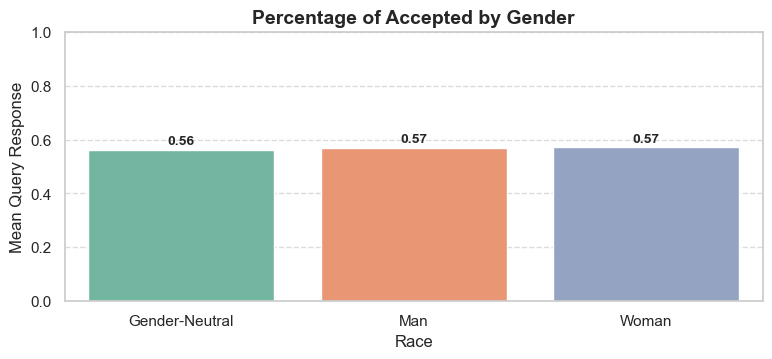

In [18]:
# Calculate and visualize the mean of query_response by gender
gender_order = sorted(df_all['gender'].unique())

mean_df_gender = df_all.groupby('gender', as_index=False)['query_response'].mean()
mean_df_gender.rename(columns={'query_response': 'mean_query_response'}, inplace=True)

plt.figure(figsize=(9, 3.5))
g = sns.barplot(
    data=mean_df_gender,
    x='gender',
    y='mean_query_response',
    palette=sns.color_palette("Set2"),
    order=gender_order
)

for index, row in mean_df_gender.iterrows():
    g.text(
        x=index,
        y=row['mean_query_response'] + 0.02,  
        s=f"{row['mean_query_response']:.2f}",
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

plt.title(f"Percentage of Accepted by Gender", fontsize=14, fontweight='bold')
plt.xlabel("Race", fontsize=12)
plt.ylabel("Mean Query Response", fontsize=12)
plt.ylim(0, 1)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Relationships Between Features

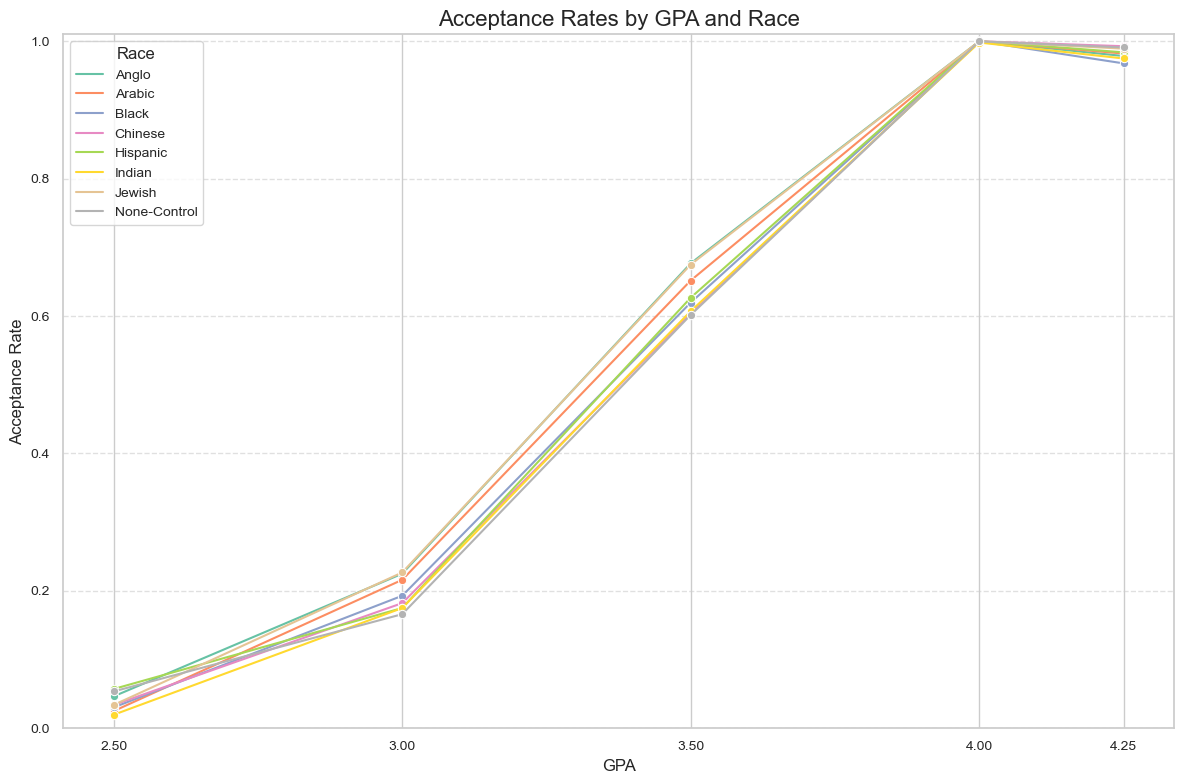

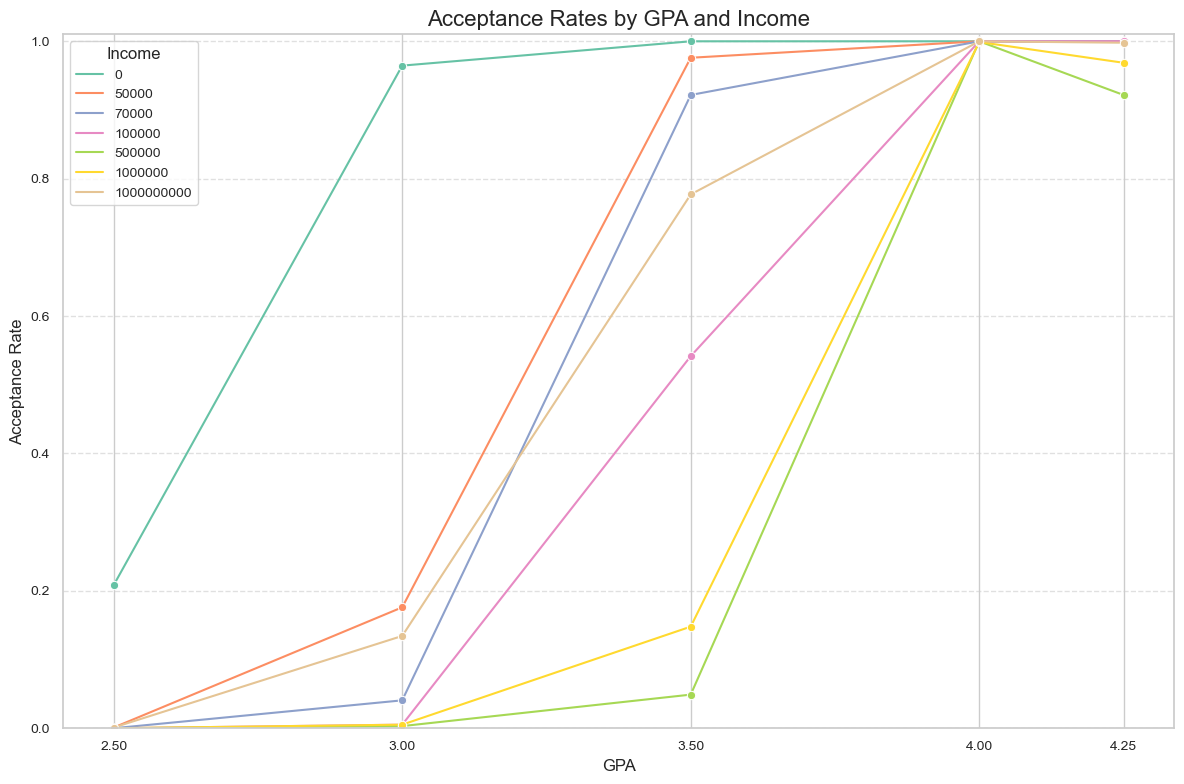

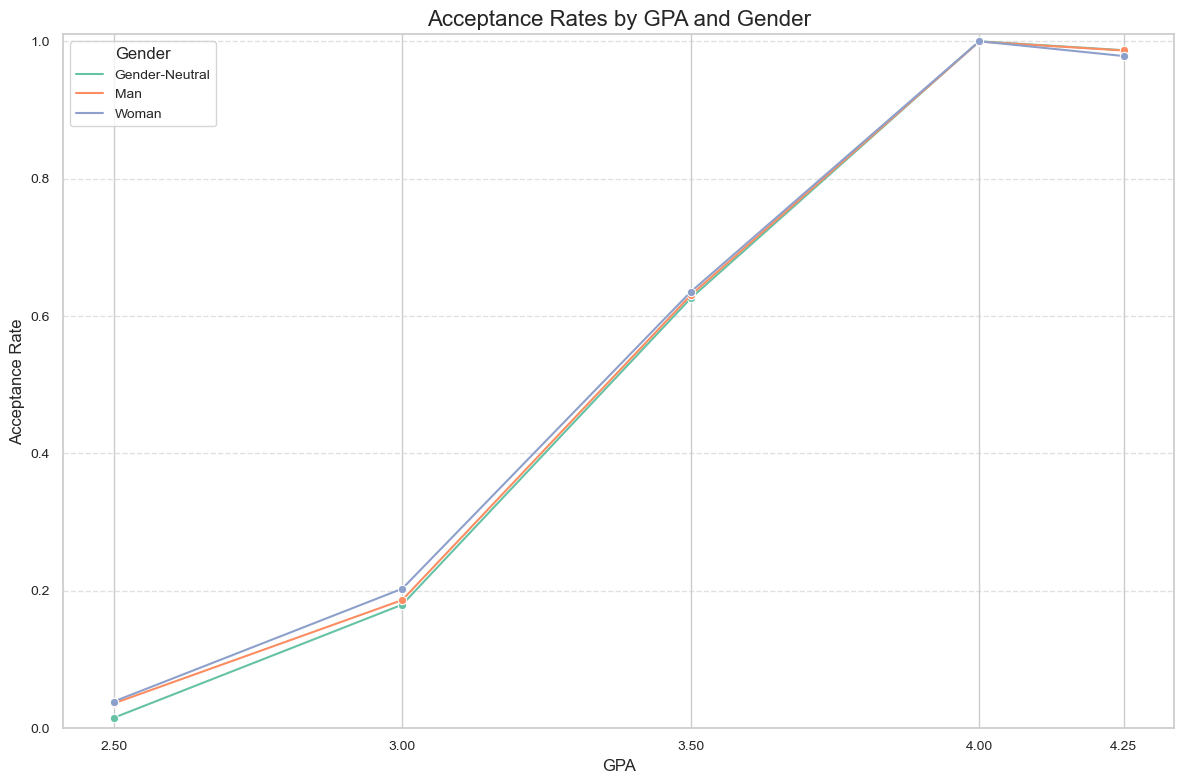

In [19]:
race_gpa = df_all.query("gender != 'Gender-Neutral'").groupby(['model', 'race', 'gpa'])['query_response'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=race_gpa,
    x='gpa',
    y='query_response',
    hue='race',
    marker='o',
    palette='Set2'
)

plt.title('Acceptance Rates by GPA and Race', fontsize=16)
plt.xlabel('GPA', fontsize=12)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.xticks(ticks=sorted(df_all['gpa'].unique()), fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.01)
plt.legend(title='Race', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

race_gpa = df_all.groupby(['model', 'income', 'gpa'])['query_response'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=race_gpa,
    x='gpa',
    y='query_response',
    hue='income',
    marker='o',
    palette='Set2'
)

plt.title('Acceptance Rates by GPA and Income', fontsize=16)
plt.xlabel('GPA', fontsize=12)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.xticks(ticks=sorted(df_all['gpa'].unique()), fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.01)
plt.legend(title='Income', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

race_gpa = df_all.groupby(['model', 'gender', 'gpa'])['query_response'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=race_gpa,
    x='gpa',
    y='query_response',
    hue='gender',
    marker='o',
    palette='Set2'
)

plt.title('Acceptance Rates by GPA and Gender', fontsize=16)
plt.xlabel('GPA', fontsize=12)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.xticks(ticks=sorted(df_all['gpa'].unique()), fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.01)
plt.legend(title='Gender', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

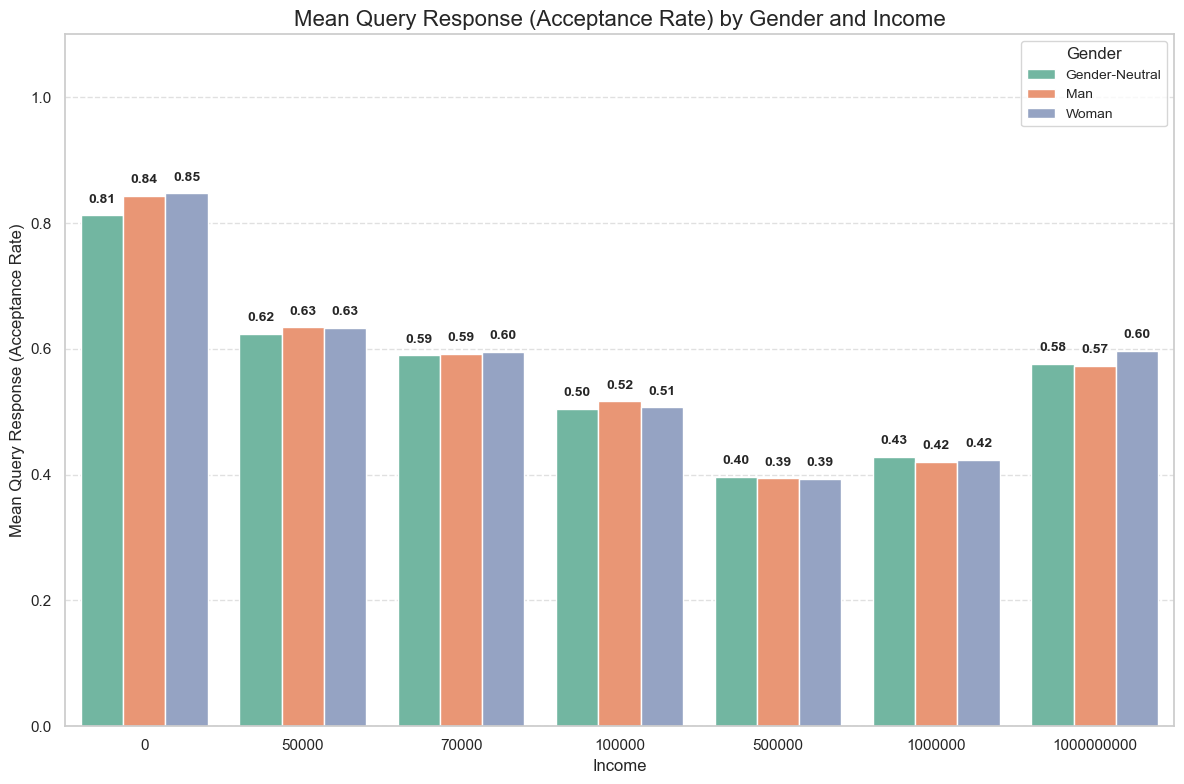

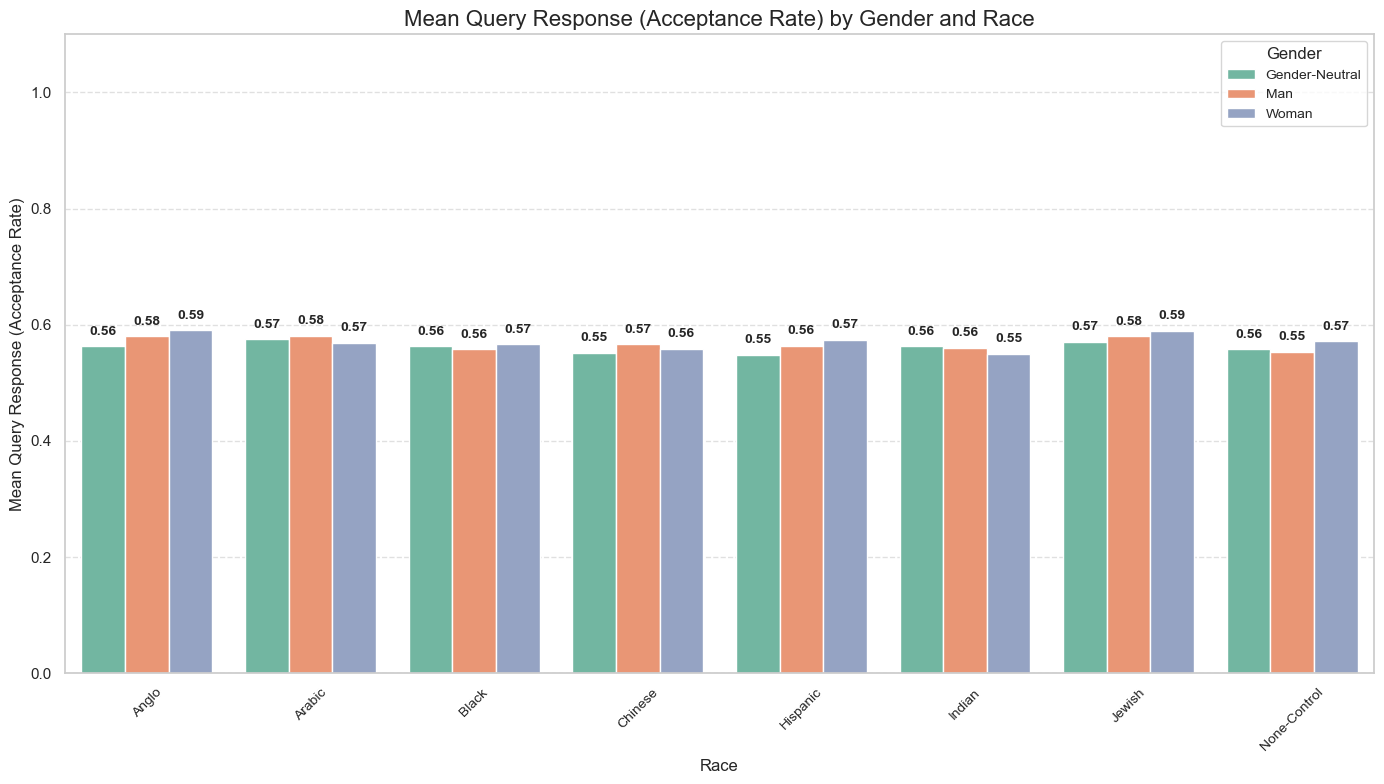

In [20]:
gender_income_mean = df_all.groupby(['gender', 'income'], as_index=False)['query_response'].mean()

gender_income_mean.rename(columns={'query_response': 'mean_query_response'}, inplace=True)

plt.figure(figsize=(12, 8))

g = sns.barplot(
    data=gender_income_mean,
    x='income',
    y='mean_query_response',
    hue='gender',
    palette='Set2'
)

for bar, row in zip(g.patches, gender_income_mean.itertuples()):
    g.text(
        x=bar.get_x() + bar.get_width() / 2, 
        y=bar.get_height() + 0.02,           
        s=f"{row.mean_query_response:.2f}", 
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

plt.title('Mean Query Response (Acceptance Rate) by Gender and Income', fontsize=16)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Mean Query Response (Acceptance Rate)', fontsize=12)
plt.ylim(0, 1.1)  
plt.legend(title='Gender', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

gender_race_mean = df_all.groupby(['gender', 'race'], as_index=False)['query_response'].mean()
gender_race_mean.rename(columns={'query_response': 'mean_query_response'}, inplace=True)

plt.figure(figsize=(14, 8))

g = sns.barplot(
    data=gender_race_mean,
    x='race',
    y='mean_query_response',
    hue='gender',
    palette='Set2'
)

for bar, row in zip(g.patches, gender_race_mean.itertuples()):
    g.text(
        x=bar.get_x() + bar.get_width() / 2,  
        y=bar.get_height() + 0.02,          
        s=f"{row.mean_query_response:.2f}", 
        ha='center',
        fontsize=10,
        fontweight='bold'
    )
plt.title('Mean Query Response (Acceptance Rate) by Gender and Race', fontsize=16)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Mean Query Response (Acceptance Rate)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylim(0, 1.1)  
plt.legend(title='Gender', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Logistic Regression

In [21]:
# Logistic regression model using gpa, income, gender, race to predict query_response

df_all['gender'] = df_all['gender'].astype('category')
df_all['race'] = df_all['race'].astype('category') 

model = smf.logit("query_response ~ gpa + income + gender + race", data=df_all)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.282290
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         query_response   No. Observations:                33600
Model:                          Logit   Df Residuals:                    33588
Method:                           MLE   Df Model:                           11
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.5874
Time:                        16:44:03   Log-Likelihood:                -9485.0
converged:                       True   LL-Null:                       -22988.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -15.7132      0.174    -90.394      0.000     -16.054     -15.373

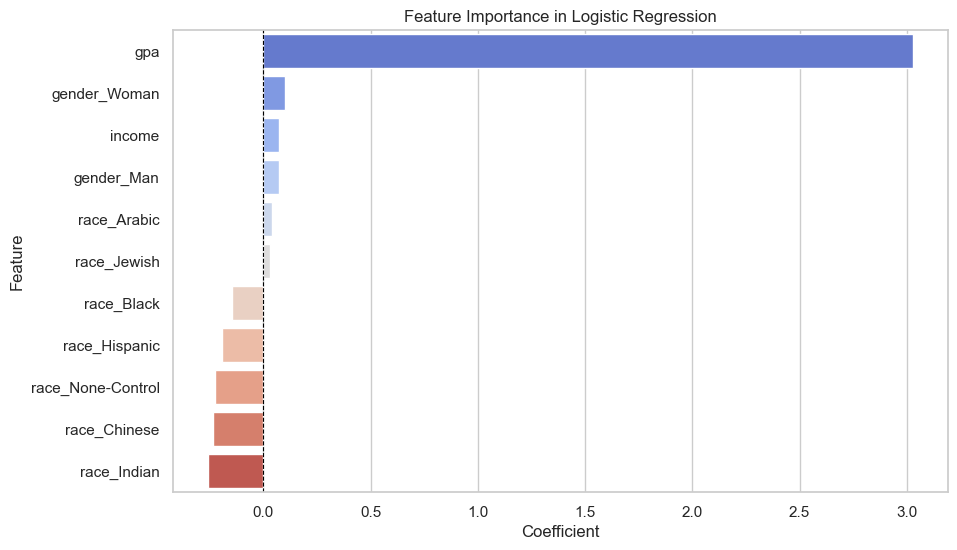

In [22]:
def logistic_regression_analysis(df):
    target = 'query_response'
    
    # Convert categorical variables using one-hot encoding
    df_encoded = pd.get_dummies(df, columns=['gender', 'race'], drop_first=True)
    
    # update features list to include one-hot encoded columns
    numeric_features = ['gpa', 'income']
    encoded_features = [col for col in df_encoded.columns if 'gender_' in col or 'race_' in col]
    features = numeric_features + encoded_features
    
    X = df_encoded[features]
    y = df_encoded[target]
    
    scaler = StandardScaler()
    X[numeric_features] = scaler.fit_transform(X[numeric_features])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_[0]
    })
    return feature_importance

# Run the analysis
feature_importance = logistic_regression_analysis(df_all)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    order=feature_importance.sort_values('Coefficient', ascending=False)['Feature']
)

plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

## ROC curve and AUC

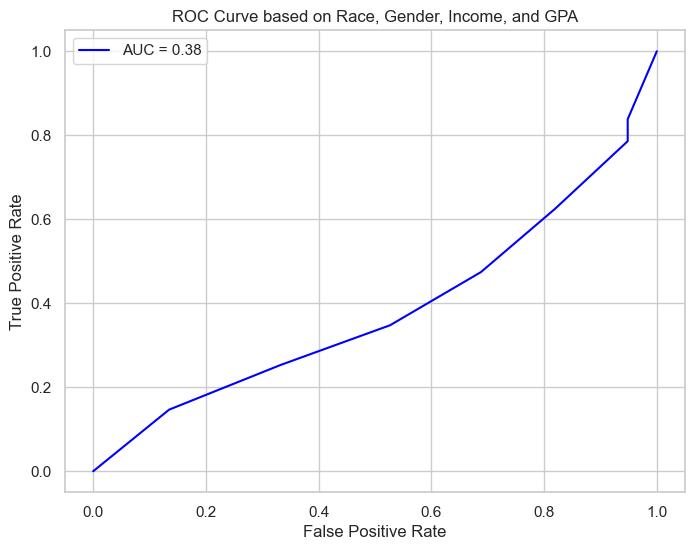

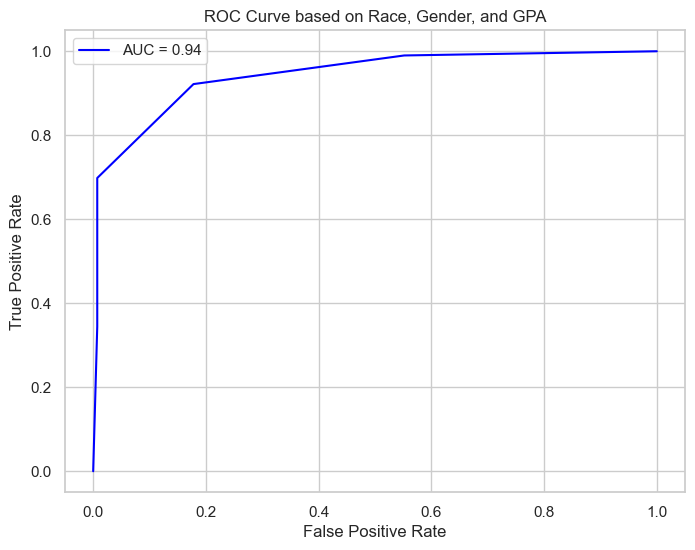

In [23]:
# ROC curve and AUC
X = df_all[['income', 'gpa'] + [col for col in df_all.columns if 'gender_' in col or 'race_' in col]]
y = df_all['query_response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_probs = lr.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color="blue")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve based on Race, Gender, Income, and GPA")
plt.legend()
plt.show()

# remove income 
X = df_all[['gpa'] + [col for col in df_all.columns if 'gender_' in col or 'race_' in col]]
y = df_all['query_response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


lr = LogisticRegression()
lr.fit(X_train, y_train)
y_probs = lr.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color="blue")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve based on Race, Gender, and GPA")
plt.legend()
plt.show()

## Chi-Squared Test

In [24]:
# Gender and query_response
contingency_gender = pd.crosstab(df_all['gender'], df_all['query_response'])
chi2_gender, p_gender, dof_gender, expected_gender = chi2_contingency(contingency_gender)
print(f"Gender Chi-Square Test: Chi2={chi2_gender}, P-value={p_gender}")

# Race and query_response
contingency_race = pd.crosstab(df_all['race'], df_all['query_response'])
chi2_race, p_race, dof_race, expected_race = chi2_contingency(contingency_race)
print(f"Race Chi-Square Test: Chi2={chi2_race}, P-value={p_race}")


Gender Chi-Square Test: Chi2=2.1477061640866966, P-value=0.3416894203860391
Race Chi-Square Test: Chi2=10.12869281888025, P-value=0.18139711802504854


## Dunn’s Test
Using Dunn's test because the data isn't evenly distributed and is appropriate when comparing more than two groups.

In [25]:
def dunn_test_all_predictors(df, predictors, response, p_adjust='bonferroni'):
    results = {}
    
    for predictor in predictors:
        print(f"\nTesting {predictor}...")
        unique_groups = df[predictor].nunique()
        
        if unique_groups > 1:  # Skip predictors with only one unique value
            # Perform Kruskal-Wallis test first
            kruskal_result = kruskal(
                *[df.loc[df[predictor] == group, response] for group in df[predictor].unique()]
            )
            print(f"Kruskal-Wallis Test Statistic: {kruskal_result.statistic:.4f}")
            print(f"P-value: {kruskal_result.pvalue:.4f}")
            
            if kruskal_result.pvalue < 0.05:
                print("Significant differences found, performing Dunn's test...")
                # Perform Dunn's test
                dunn_result = posthoc_dunn(
                    df,
                    val_col=response,    # Response column
                    group_col=predictor,  # Predictor column
                    p_adjust=p_adjust    # P-value adjustment method
                )
                results[predictor] = dunn_result
            else:
                print("No significant differences found (Kruskal-Wallis test).")
        else:
            print(f"Skipped {predictor} (only one unique group).")
    
    return results


categorical_predictors = ['gender', 'race', 'gpa', 'income'] 
response_variable = 'query_response'

# Run Dunn's test for all predictors
dunn_results = dunn_test_all_predictors(df_all, categorical_predictors, response_variable)

# Display results only if the predictor is statistically significant
for predictor, result in dunn_results.items():
    print(f"\nDunn's Test Results for {predictor}:")
    print(result)


Testing gender...
Kruskal-Wallis Test Statistic: 2.1476
P-value: 0.3417
No significant differences found (Kruskal-Wallis test).

Testing race...
Kruskal-Wallis Test Statistic: 10.1284
P-value: 0.1814
No significant differences found (Kruskal-Wallis test).

Testing gpa...
Kruskal-Wallis Test Statistic: 21782.0216
P-value: 0.0000
Significant differences found, performing Dunn's test...

Testing income...
Kruskal-Wallis Test Statistic: 2539.5187
P-value: 0.0000
Significant differences found, performing Dunn's test...

Dunn's Test Results for gpa:
              2.50          3.00  3.50      4.00      4.25
2.50  1.000000e+00  5.339478e-77   0.0  0.000000  0.000000
3.00  5.339478e-77  1.000000e+00   0.0  0.000000  0.000000
3.50  0.000000e+00  0.000000e+00   1.0  0.000000  0.000000
4.00  0.000000e+00  0.000000e+00   0.0  1.000000  0.650047
4.25  0.000000e+00  0.000000e+00   0.0  0.650047  1.000000

Dunn's Test Results for income:
               0              50000          70000          10

In [26]:
def calculate_gaps(group, column):
    mean_values = group.groupby(column)['query_response'].mean()
    median_values = group.groupby(column)['query_response'].median()

    # Get highest and lowest groups for mean and median
    max_mean_group = mean_values.idxmax()
    min_mean_group = mean_values.idxmin()
    max_median_group = median_values.idxmax()
    min_median_group = median_values.idxmin()

    return pd.Series({
        f'max_mean_{column}': max_mean_group,
        f'max_mean_response_{column}': mean_values[max_mean_group],
        f'min_mean_{column}': min_mean_group,
        f'min_mean_response_{column}': mean_values[min_mean_group],
        f'mean_gap_{column}': mean_values[max_mean_group] - mean_values[min_mean_group],
        f'max_median_{column}': max_median_group,
        f'max_median_response_{column}': median_values[max_median_group],
        f'min_median_{column}': min_median_group,
        f'min_median_response_{column}': median_values[min_median_group],
        f'median_gap_{column}': median_values[max_median_group] - median_values[min_median_group]
    })

# Apply to each predictor
gpa_gaps = calculate_gaps(df_all, 'gpa')
income_gaps = calculate_gaps(df_all, 'income')
gender_gaps = calculate_gaps(df_all, 'gender')
race_gaps = calculate_gaps(df_all, 'race')


print(gpa_gaps)
print()
print(income_gaps)
print()
print(gender_gaps)
print()
print(race_gaps)

max_mean_gpa               4.000000
max_mean_response_gpa      0.999851
min_mean_gpa               2.500000
min_mean_response_gpa      0.030060
mean_gap_gpa               0.969792
max_median_gpa             3.500000
max_median_response_gpa    1.000000
min_median_gpa             2.500000
min_median_response_gpa    0.000000
median_gap_gpa             1.000000
dtype: float64

max_mean_income                    0.000000
max_mean_response_income           0.834583
min_mean_income               500000.000000
min_mean_response_income           0.394792
mean_gap_income                    0.439792
max_median_income                  0.000000
max_median_response_income         1.000000
min_median_income             500000.000000
min_median_response_income         0.000000
median_gap_income                  1.000000
dtype: float64

max_mean_gender                        Woman
max_mean_response_gender            0.571161
min_mean_gender               Gender-Neutral
min_mean_response_gender         

In [27]:
print("Elapsed time:", datetime.datetime.now() - start_run)

Elapsed time: 0:00:04.445083
